#Supervised Contrastive Learning

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Implementation by G. M. Shahariar Shibli

#Version and GPU check

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
!nvidia-smi

Wed Mar 22 16:55:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Installation

In [ ]:
%%capture
!pip3 install tensorflow-addons
!pip3 install tf_keras_vis

#Imports

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras

import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import datetime
import glob
import os

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

#Configurations

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
CROP_TO = 224

num_classes = 23
input_shape = (224, 224, 3)

LR = 2e-5
shuffler = 1024

#Data Augmentation

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image, label):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image, label

# Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cecum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/cecum/*.*')
ileum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ileum/*.*')
retroflex_rectum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_rectum/*.*')
hemorrhoids = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/hemorrhoids/*.*')
polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/polyps/*.*')
ulcerative_colitis_grade_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-0-1/*.*')
ulcerative_colitis_grade_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1/*.*')
ulcerative_colitis_grade_1_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1-2/*.*')
ulcerative_colitis_grade_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2/*.*')
ulcerative_colitis_grade_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2-3/*.*')
ulcerative_colitis_grade_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-3/*.*')
bbps_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-0-1/*.*')
bbps_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-2-3/*.*')
impacted_stool = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/impacted-stool/*.*')
dyed_lifted_polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-lifted-polyps/*.*')
dyed_resection_margins = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-resection-margins/*.*')
pylorus = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/pylorus/*.*')
retroflex_stomach = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_stomach/*.*')
z_line = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/z_line/*.*')
barretts = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts/*.*')
barretts_short_segment = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts-short-segment/*.*')
esophagitis_a = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-a/*.*')
esophagitis_b_d = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-b-d/*.*')

In [ ]:
dataset = {0 :cecum, 1:ileum, 2:retroflex_rectum, 3:hemorrhoids, 4:polyps,5:ulcerative_colitis_grade_0_1,6:ulcerative_colitis_grade_1,7:ulcerative_colitis_grade_1_2,8:ulcerative_colitis_grade_2,9:ulcerative_colitis_grade_2_3,10:ulcerative_colitis_grade_3,11:bbps_0_1 ,12:bbps_2_3,13:impacted_stool,14:dyed_lifted_polyps,15:dyed_resection_margins,16:pylorus,17:retroflex_stomach,18:z_line,19:barretts,20:barretts_short_segment,21:esophagitis_a ,22:esophagitis_b_d }

In [ ]:
def combineDataAndLabel(width, height, dataset):

  data = []
  labels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
          target_size= (width,height))
          image=np.array(image)
          data.append(image)
          count=count+1
          labels.append(cls)
      print(f"\n\processed {count} images \n\n")


  # for i in cecum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(0)

  # for i in ileum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(1)
  # for i in pylorus:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(2)
  # for i in retroflex_rectum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(3)
  # for i in retroflex_stomach:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(4)
  # for i in z_line:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(5)

  data = np.array(data)
  labels = np.array(labels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ML/combinedData_224', data)
  np.save('/content/drive/MyDrive/ML/combinedLabels_224', labels)
  print(f"\n\nSaved")

  return data, labels


In [ ]:
import os
data = []
labels = []
if(os.path.isfile("/content/drive/MyDrive/ML/combinedData_224.npy") and os.path.isfile("/content/drive/MyDrive/ML/combinedLabels_224.npy")):
  data = np.load("/content/drive/MyDrive/ML/combinedData_224.npy")
  labels = np.load("/content/drive/MyDrive/ML/combinedLabels_224.npy")
else:
  data, labels = combineDataAndLabel(224,224,dataset)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42,stratify = labels)

In [ ]:
# Load data
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (8529, 224, 224, 3) - y_train shape: (8529,)
x_test shape: (2133, 224, 224, 3) - y_test shape: (2133,)


In [ ]:
#contrastive training
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (train_ds.shuffle(shuffler).map(custom_augment).batch(BATCH_SIZE))

#cross-entropy training
train_ds2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffler).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffler).batch(BATCH_SIZE)

#Contrastive Loss Functions

Max Margin Loss, N pairs loss, Triplet loss, NT-XENT loss

In [ ]:
def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


#def square_to_vec(D):
   #'''Convert a squared form pdist matrix to vector form.
    #'''
 #   n = D.shape[0]
  #  triu_idx = np.triu_indices(n, k=1)
   # d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    #return d_vec
def square_to_vec(D):
    with tf.name_scope("square_to_vec"):
        n = D.shape[0]
        triu_idx = np.triu_indices(n, k=1)
        triu_idx_int = np.array(triu_idx).astype(np.int32)
        d_vec = tf.gather_nd(D, list(zip(triu_idx_int[0], triu_idx_int[1])))
        return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss.
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from:
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

#Encoder with Contrastive Learning

In [ ]:
#Layer Batch Normalization
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [ ]:
# Encoder Architecture
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True
    h = base_model.output
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    normalized_embed = UnitNormLayer()(projection_3)

    resnet_simclr = Model(base_model.inputs, normalized_embed)

    return resnet_simclr

In [ ]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model = get_resnet_simclr(512, 256, 128)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
train_loss_cl = tf.keras.metrics.Mean(name='train_loss')
test_loss_cl = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = model(x, training=True)
        loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)

In [ ]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')
    test_loss_cl(t_loss)

In [ ]:
#Encoder training
train_loss_dict = {}
test_loss_dict = {}

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()

    for x, y in tqdm(train_ds):
        train_step_contrastive(x, y)

    for x_te, y_te in test_ds:
        test_step_contrastive(x_te, y_te)

    template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,train_loss_cl.result(),test_loss_cl.result()))
    train_loss_dict[epoch] = train_loss_cl.result().numpy()*100
    test_loss_dict[epoch] = test_loss_cl.result().numpy()*100

100%|██████████| 134/134 [02:01<00:00,  1.10it/s]


Epoch 1, Training Loss: 0.08103005588054657, Test Loss: 0.9126408100128174


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 2, Training Loss: 0.07535471022129059, Test Loss: 0.8232858777046204


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 3, Training Loss: 0.0745871514081955, Test Loss: 0.45657551288604736


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 4, Training Loss: 0.07319837063550949, Test Loss: 0.10909255594015121


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 5, Training Loss: 0.07182487100362778, Test Loss: 0.07264511287212372


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 6, Training Loss: 0.07036522775888443, Test Loss: 0.06790566444396973


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 7, Training Loss: 0.0698629841208458, Test Loss: 0.06654415279626846


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 8, Training Loss: 0.06824467331171036, Test Loss: 0.06643715500831604


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 9, Training Loss: 0.06861710548400879, Test Loss: 0.06579574197530746


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 10, Training Loss: 0.06692230701446533, Test Loss: 0.06460591405630112


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 11, Training Loss: 0.06697887927293777, Test Loss: 0.06366279721260071


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 12, Training Loss: 0.06630502641201019, Test Loss: 0.06445044279098511


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 13, Training Loss: 0.06480908393859863, Test Loss: 0.06269662827253342


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 14, Training Loss: 0.06520840525627136, Test Loss: 0.061454057693481445


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 15, Training Loss: 0.06530856341123581, Test Loss: 0.06079665198922157


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 16, Training Loss: 0.06484723091125488, Test Loss: 0.059595879167318344


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 17, Training Loss: 0.06401078402996063, Test Loss: 0.05924753472208977


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 18, Training Loss: 0.064419686794281, Test Loss: 0.0594969280064106


100%|██████████| 134/134 [01:21<00:00,  1.63it/s]


Epoch 19, Training Loss: 0.06396341323852539, Test Loss: 0.060691140592098236


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 20, Training Loss: 0.062117889523506165, Test Loss: 0.05918503552675247


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 21, Training Loss: 0.06256191432476044, Test Loss: 0.058176882565021515


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 22, Training Loss: 0.06225041672587395, Test Loss: 0.05724811553955078


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 23, Training Loss: 0.06218038499355316, Test Loss: 0.05693379044532776


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 24, Training Loss: 0.062159985303878784, Test Loss: 0.05691194906830788


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 25, Training Loss: 0.062229420989751816, Test Loss: 0.05590023100376129


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 26, Training Loss: 0.06123483180999756, Test Loss: 0.05532494932413101


100%|██████████| 134/134 [01:21<00:00,  1.63it/s]


Epoch 27, Training Loss: 0.06197225674986839, Test Loss: 0.05571189522743225


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 28, Training Loss: 0.06093734875321388, Test Loss: 0.053967203944921494


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 29, Training Loss: 0.06026844307780266, Test Loss: 0.05327806621789932


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 30, Training Loss: 0.06067927926778793, Test Loss: 0.053959012031555176


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 31, Training Loss: 0.059891972690820694, Test Loss: 0.05342945083975792


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 32, Training Loss: 0.05968964099884033, Test Loss: 0.05268409103155136


100%|██████████| 134/134 [01:21<00:00,  1.64it/s]


Epoch 33, Training Loss: 0.059732068330049515, Test Loss: 0.05382784456014633


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 34, Training Loss: 0.05871851369738579, Test Loss: 0.05121826380491257


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 35, Training Loss: 0.05836869031190872, Test Loss: 0.05271891504526138


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 36, Training Loss: 0.05839341878890991, Test Loss: 0.05174171179533005


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 37, Training Loss: 0.05773713439702988, Test Loss: 0.05046970769762993


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 38, Training Loss: 0.05702781677246094, Test Loss: 0.049568191170692444


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 39, Training Loss: 0.05788436532020569, Test Loss: 0.04932178929448128


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 40, Training Loss: 0.05680512264370918, Test Loss: 0.04851328954100609


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 41, Training Loss: 0.056745871901512146, Test Loss: 0.049447253346443176


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 42, Training Loss: 0.05601252615451813, Test Loss: 0.048588547855615616


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 43, Training Loss: 0.05670817196369171, Test Loss: 0.04661228135228157


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 44, Training Loss: 0.055605895817279816, Test Loss: 0.048010680824518204


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 45, Training Loss: 0.05640222504734993, Test Loss: 0.04575520008802414


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 46, Training Loss: 0.05501431226730347, Test Loss: 0.04612753540277481


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 47, Training Loss: 0.05463545769453049, Test Loss: 0.0467367023229599


100%|██████████| 134/134 [01:04<00:00,  2.08it/s]


Epoch 48, Training Loss: 0.055015310645103455, Test Loss: 0.04527156427502632


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 49, Training Loss: 0.054307080805301666, Test Loss: 0.04585913196206093


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]


Epoch 50, Training Loss: 0.053485024720430374, Test Loss: 0.045350220054388046


In [ ]:
from pickle import load, dump
from matplotlib.pylab import plt
from numpy import arange

In [ ]:
# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_EfficientNetB0.pkl', 'wb') as file:
    dump(train_loss_dict, file)

# Save the validation loss values
with open('/content/drive/MyDrive/ML/test_loss_EfficientNetB0.pkl', 'wb') as file:
    dump(test_loss_dict, file)

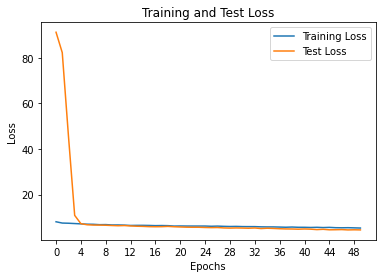

In [ ]:
# Load the training and validation loss dictionaries
train_loss = load(open('/content/drive/MyDrive/ML/train_loss_EfficientNetB0.pkl', 'rb'))
test_loss = load(open('/content/drive/MyDrive/ML/test_loss_EfficientNetB0.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
test_values = test_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(50)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 50, 4))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filename =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "EfficientNetB0_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filename)

model.save_weights(filename)

/content/drive/MyDrive/Colab Notebooks/20230311-181348EfficientNetB0_simclr.h5


#Classifier with frozen Encoder

In [ ]:
new_model = get_resnet_simclr(512, 256, 128)
new_model.load_weights("/content/drive/MyDrive/Colab Notebooks/20230311-181348EfficientNetB0_simclr.h5")

In [ ]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [ ]:
def Classifier_Network():
    '''For stage 2, simply a softmax on top of the Encoder.
    '''
    contrast_model = new_model
    contrast_model.trainable = False
    embedd = contrast_model.output
    features = Dropout(0.5)(embedd)
    features = Dense(64, activation="relu")(features)
    features = Dropout(0.5)(features)
    outputs  = Dense(num_classes, activation="softmax")(features)

    classifier_model = Model(contrast_model.inputs, outputs)

    return classifier_model

In [ ]:
classifier = Classifier_Network()

In [ ]:
classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [ ]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
sample_weight = tf.random.uniform((tf.shape(y_train)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
sample_weight

<tf.Tensor: shape=(8529, 1), dtype=float32, numpy=
array([[0.7861433 ],
       [0.49920297],
       [0.29927063],
       ...,
       [0.05716491],
       [0.14451802],
       [0.6533736 ]], dtype=float32)>

In [ ]:
@tf.function
# train step for the 2nd stage
def train_step(x, y,sample_weight):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        y_preds = classifier(x, training=True)
        loss = cce_loss_obj(y, y_preds,sample_weight = sample_weight)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss,
                              classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(gradients,
                                  classifier.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [ ]:
@tf.function
def test_step(x, y):
    y_preds = classifier(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [ ]:
#classifier training
train_loss_dict_classifier = {}
test_loss_dict_classifier = {}
train_acc_dict = {}
test_acc_dict = {}

for epoch in range(220):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()


    for x, y in tqdm(train_ds2):
        #print(x.shape,y.shape)
        sample_weight = tf.random.uniform((tf.shape(x)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
        train_step(x, y,sample_weight)

    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    template = 'Epoch {}, Train Loss: {}, Train Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,train_loss.result(), train_acc.result() * 100,test_loss.result(),test_acc.result() * 100))
    train_loss_dict_classifier[epoch] = train_loss.result().numpy()
    test_loss_dict_classifier[epoch] = test_loss.result().numpy()
    train_acc_dict[epoch] = train_acc.result().numpy()*100
    test_acc_dict[epoch] = test_acc.result().numpy()*100

100%|██████████| 134/134 [00:34<00:00,  3.91it/s]


Epoch 1, Train Loss: 1.5725741386413574, Train Acc: 3.8808770179748535, Test Loss: 3.132297992706299, Test Acc: 3.516174554824829


100%|██████████| 134/134 [00:13<00:00,  9.61it/s]


Epoch 2, Train Loss: 1.564864158630371, Train Acc: 4.666431903839111, Test Loss: 3.1103458404541016, Test Acc: 3.609938859939575


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 3, Train Loss: 1.5531079769134521, Train Acc: 5.709930896759033, Test Loss: 3.0880331993103027, Test Acc: 4.078762054443359


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 4, Train Loss: 1.551717758178711, Train Acc: 6.554109573364258, Test Loss: 3.0658583641052246, Test Acc: 6.704172611236572


100%|██████████| 134/134 [00:14<00:00,  9.52it/s]


Epoch 5, Train Loss: 1.5255292654037476, Train Acc: 7.5507097244262695, Test Loss: 3.0438640117645264, Test Acc: 9.93905258178711


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 6, Train Loss: 1.518434762954712, Train Acc: 8.781803131103516, Test Loss: 3.021549940109253, Test Acc: 14.486639022827148


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 7, Train Loss: 1.5071730613708496, Train Acc: 9.485285758972168, Test Loss: 2.9971923828125, Test Acc: 19.409282684326172


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 8, Train Loss: 1.5035209655761719, Train Acc: 12.146793365478516, Test Loss: 2.9738657474517822, Test Acc: 24.425691604614258


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 9, Train Loss: 1.487954020500183, Train Acc: 13.68272876739502, Test Loss: 2.94635009765625, Test Acc: 33.75527572631836


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 10, Train Loss: 1.4905132055282593, Train Acc: 15.394536018371582, Test Loss: 2.920064926147461, Test Acc: 37.78715515136719


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 11, Train Loss: 1.4557901620864868, Train Acc: 17.17669105529785, Test Loss: 2.891845941543579, Test Acc: 41.537742614746094


100%|██████████| 134/134 [00:14<00:00,  9.23it/s]


Epoch 12, Train Loss: 1.4563809633255005, Train Acc: 19.732675552368164, Test Loss: 2.8626410961151123, Test Acc: 43.97562026977539


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 13, Train Loss: 1.4420396089553833, Train Acc: 20.823074340820312, Test Loss: 2.8326683044433594, Test Acc: 45.66338348388672


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 14, Train Loss: 1.4329155683517456, Train Acc: 23.379058837890625, Test Loss: 2.802530288696289, Test Acc: 46.74168014526367


100%|██████████| 134/134 [00:14<00:00,  9.25it/s]


Epoch 15, Train Loss: 1.423986792564392, Train Acc: 23.883222579956055, Test Loss: 2.7681126594543457, Test Acc: 48.570091247558594


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 16, Train Loss: 1.3946484327316284, Train Acc: 25.817798614501953, Test Loss: 2.7380332946777344, Test Acc: 49.55461883544922


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 17, Train Loss: 1.387683391571045, Train Acc: 27.142688751220703, Test Loss: 2.702254056930542, Test Acc: 51.00796890258789


100%|██████████| 134/134 [00:14<00:00,  9.26it/s]


Epoch 18, Train Loss: 1.3719406127929688, Train Acc: 28.3503360748291, Test Loss: 2.6719233989715576, Test Acc: 51.85185241699219


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 19, Train Loss: 1.357397437095642, Train Acc: 30.765623092651367, Test Loss: 2.6357638835906982, Test Acc: 52.367557525634766


100%|██████████| 134/134 [00:14<00:00,  9.36it/s]


Epoch 20, Train Loss: 1.345113754272461, Train Acc: 31.246337890625, Test Loss: 2.601963758468628, Test Acc: 53.2114372253418


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 21, Train Loss: 1.3186075687408447, Train Acc: 33.169185638427734, Test Loss: 2.567870855331421, Test Acc: 53.49272918701172


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 22, Train Loss: 1.3210148811340332, Train Acc: 33.45058059692383, Test Loss: 2.534242630004883, Test Acc: 53.77402877807617


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 23, Train Loss: 1.3110593557357788, Train Acc: 35.396881103515625, Test Loss: 2.500110387802124, Test Acc: 54.055320739746094


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 24, Train Loss: 1.2803701162338257, Train Acc: 35.64310073852539, Test Loss: 2.466876983642578, Test Acc: 54.00843811035156


100%|██████████| 134/134 [00:14<00:00,  9.28it/s]


Epoch 25, Train Loss: 1.2748637199401855, Train Acc: 37.026615142822266, Test Loss: 2.4375038146972656, Test Acc: 54.336612701416016


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 26, Train Loss: 1.2403563261032104, Train Acc: 38.093563079833984, Test Loss: 2.403238296508789, Test Acc: 54.477264404296875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 27, Train Loss: 1.2581684589385986, Train Acc: 37.89424133300781, Test Loss: 2.3700060844421387, Test Acc: 54.477264404296875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 28, Train Loss: 1.2266769409179688, Train Acc: 39.019813537597656, Test Loss: 2.337247848510742, Test Acc: 54.477264404296875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 29, Train Loss: 1.214860439300537, Train Acc: 40.71989822387695, Test Loss: 2.308135509490967, Test Acc: 54.57102584838867


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 30, Train Loss: 1.204901933670044, Train Acc: 41.48200225830078, Test Loss: 2.2806077003479004, Test Acc: 54.61791229248047


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 31, Train Loss: 1.1808432340621948, Train Acc: 41.30613327026367, Test Loss: 2.246161460876465, Test Acc: 54.71167755126953


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 32, Train Loss: 1.1910114288330078, Train Acc: 41.24750900268555, Test Loss: 2.2166669368743896, Test Acc: 54.89920425415039


100%|██████████| 134/134 [00:14<00:00,  9.28it/s]


Epoch 33, Train Loss: 1.1592625379562378, Train Acc: 43.580726623535156, Test Loss: 2.1874141693115234, Test Acc: 55.18049621582031


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 34, Train Loss: 1.1501580476760864, Train Acc: 43.85039138793945, Test Loss: 2.156238555908203, Test Acc: 55.18049621582031


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 35, Train Loss: 1.1404750347137451, Train Acc: 44.38972854614258, Test Loss: 2.1285409927368164, Test Acc: 55.22738265991211


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 36, Train Loss: 1.1260591745376587, Train Acc: 44.823543548583984, Test Loss: 2.099492311477661, Test Acc: 55.36802291870117


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 37, Train Loss: 1.1108765602111816, Train Acc: 45.29253387451172, Test Loss: 2.0756747722625732, Test Acc: 55.461788177490234


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 38, Train Loss: 1.1060184240341187, Train Acc: 46.17188262939453, Test Loss: 2.0536692142486572, Test Acc: 55.836849212646484


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 39, Train Loss: 1.1030750274658203, Train Acc: 45.667724609375, Test Loss: 2.0235354900360107, Test Acc: 55.836849212646484


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 40, Train Loss: 1.0743142366409302, Train Acc: 46.8519172668457, Test Loss: 2.0003955364227295, Test Acc: 55.78996658325195


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 41, Train Loss: 1.0712724924087524, Train Acc: 47.590576171875, Test Loss: 1.9657704830169678, Test Acc: 56.118141174316406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 42, Train Loss: 1.0608148574829102, Train Acc: 46.88709259033203, Test Loss: 1.9429267644882202, Test Acc: 56.1650276184082


100%|██████████| 134/134 [00:14<00:00,  9.27it/s]


Epoch 43, Train Loss: 1.0624454021453857, Train Acc: 47.26227951049805, Test Loss: 1.9203486442565918, Test Acc: 56.07126235961914


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 44, Train Loss: 1.049032211303711, Train Acc: 48.118186950683594, Test Loss: 1.899328351020813, Test Acc: 56.1650276184082


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 45, Train Loss: 1.031593680381775, Train Acc: 49.43135070800781, Test Loss: 1.880220890045166, Test Acc: 56.30567169189453


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 46, Train Loss: 1.0184330940246582, Train Acc: 49.818267822265625, Test Loss: 1.859513282775879, Test Acc: 56.39943313598633


100%|██████████| 134/134 [00:14<00:00,  9.24it/s]


Epoch 47, Train Loss: 1.013574481010437, Train Acc: 48.446475982666016, Test Loss: 1.8328032493591309, Test Acc: 56.446319580078125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 48, Train Loss: 1.0171011686325073, Train Acc: 48.446475982666016, Test Loss: 1.8123154640197754, Test Acc: 56.49320602416992


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 49, Train Loss: 0.9900113940238953, Train Acc: 49.09133529663086, Test Loss: 1.7910853624343872, Test Acc: 56.72761154174805


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 50, Train Loss: 0.9842865467071533, Train Acc: 49.02098846435547, Test Loss: 1.7758562564849854, Test Acc: 56.915138244628906


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 51, Train Loss: 0.9963418841362, Train Acc: 49.72446823120117, Test Loss: 1.7505909204483032, Test Acc: 57.1026725769043


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 52, Train Loss: 0.9562919735908508, Train Acc: 50.134830474853516, Test Loss: 1.7354239225387573, Test Acc: 57.14955139160156


100%|██████████| 134/134 [00:14<00:00,  9.36it/s]


Epoch 53, Train Loss: 0.9583861231803894, Train Acc: 49.57204818725586, Test Loss: 1.7135766744613647, Test Acc: 57.19643783569336


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 54, Train Loss: 0.9526135921478271, Train Acc: 50.34587860107422, Test Loss: 1.6978435516357422, Test Acc: 57.19643783569336


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 55, Train Loss: 0.9466519355773926, Train Acc: 50.662445068359375, Test Loss: 1.6812516450881958, Test Acc: 57.1026725769043


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 56, Train Loss: 0.9474073052406311, Train Acc: 50.92039108276367, Test Loss: 1.6681410074234009, Test Acc: 57.14955139160156


100%|██████████| 134/134 [00:14<00:00,  9.26it/s]


Epoch 57, Train Loss: 0.9310966730117798, Train Acc: 51.00246047973633, Test Loss: 1.6512430906295776, Test Acc: 57.29020309448242


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 58, Train Loss: 0.93631511926651, Train Acc: 51.57697296142578, Test Loss: 1.6438921689987183, Test Acc: 57.243316650390625


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 59, Train Loss: 0.927524745464325, Train Acc: 50.09965896606445, Test Loss: 1.6087790727615356, Test Acc: 57.29020309448242


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 60, Train Loss: 0.9241371154785156, Train Acc: 51.623870849609375, Test Loss: 1.6046757698059082, Test Acc: 57.430850982666016


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 61, Train Loss: 0.9066437482833862, Train Acc: 51.82319259643555, Test Loss: 1.592159390449524, Test Acc: 57.430850982666016


100%|██████████| 134/134 [00:14<00:00,  9.31it/s]


Epoch 62, Train Loss: 0.902355432510376, Train Acc: 51.85836410522461, Test Loss: 1.5707197189331055, Test Acc: 57.52461624145508


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 63, Train Loss: 0.8977304697036743, Train Acc: 52.66736602783203, Test Loss: 1.5527124404907227, Test Acc: 57.47772979736328


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 64, Train Loss: 0.8930203318595886, Train Acc: 51.846641540527344, Test Loss: 1.5455923080444336, Test Acc: 57.618377685546875


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 65, Train Loss: 0.8922867178916931, Train Acc: 52.06940841674805, Test Loss: 1.5372414588928223, Test Acc: 57.71214294433594


100%|██████████| 134/134 [00:14<00:00,  9.31it/s]


Epoch 66, Train Loss: 0.8718042969703674, Train Acc: 52.79634094238281, Test Loss: 1.515199065208435, Test Acc: 57.665260314941406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 67, Train Loss: 0.8609279990196228, Train Acc: 52.22182846069336, Test Loss: 1.511433482170105, Test Acc: 57.71214294433594


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 68, Train Loss: 0.8762737512588501, Train Acc: 53.054283142089844, Test Loss: 1.4878137111663818, Test Acc: 57.805908203125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 69, Train Loss: 0.8686084747314453, Train Acc: 52.444602966308594, Test Loss: 1.4879648685455322, Test Acc: 57.805908203125


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 70, Train Loss: 0.8552385568618774, Train Acc: 53.300506591796875, Test Loss: 1.4777277708053589, Test Acc: 57.852787017822266


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 71, Train Loss: 0.8450570702552795, Train Acc: 52.69082260131836, Test Loss: 1.4571404457092285, Test Acc: 57.805908203125


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 72, Train Loss: 0.8470189571380615, Train Acc: 53.6053466796875, Test Loss: 1.4534820318222046, Test Acc: 57.71214294433594


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 73, Train Loss: 0.8448809385299683, Train Acc: 52.948760986328125, Test Loss: 1.4372819662094116, Test Acc: 57.430850982666016


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 74, Train Loss: 0.8352392911911011, Train Acc: 53.359127044677734, Test Loss: 1.4300531148910522, Test Acc: 57.52461624145508


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 75, Train Loss: 0.8441789746284485, Train Acc: 53.687416076660156, Test Loss: 1.414756417274475, Test Acc: 57.52461624145508


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 76, Train Loss: 0.840749204158783, Train Acc: 52.74944305419922, Test Loss: 1.4211472272872925, Test Acc: 57.665260314941406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 77, Train Loss: 0.8232457041740417, Train Acc: 53.74604415893555, Test Loss: 1.4042277336120605, Test Acc: 57.7590217590332


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 78, Train Loss: 0.8260127305984497, Train Acc: 53.769493103027344, Test Loss: 1.3942002058029175, Test Acc: 57.946556091308594


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 79, Train Loss: 0.8186050653457642, Train Acc: 53.08945846557617, Test Loss: 1.3943555355072021, Test Acc: 58.040321350097656


100%|██████████| 134/134 [00:14<00:00,  9.27it/s]


Epoch 80, Train Loss: 0.8231632709503174, Train Acc: 53.663970947265625, Test Loss: 1.3757193088531494, Test Acc: 58.040321350097656


100%|██████████| 134/134 [00:14<00:00,  9.35it/s]


Epoch 81, Train Loss: 0.8085664510726929, Train Acc: 53.42947769165039, Test Loss: 1.3598757982254028, Test Acc: 58.227848052978516


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 82, Train Loss: 0.8176868557929993, Train Acc: 54.3088264465332, Test Loss: 1.3717577457427979, Test Acc: 58.32161331176758


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 83, Train Loss: 0.8007563948631287, Train Acc: 53.40602493286133, Test Loss: 1.3555721044540405, Test Acc: 58.46226119995117


100%|██████████| 134/134 [00:14<00:00,  9.27it/s]


Epoch 84, Train Loss: 0.7837649583816528, Train Acc: 54.26192855834961, Test Loss: 1.3441777229309082, Test Acc: 58.69667053222656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 85, Train Loss: 0.8044726848602295, Train Acc: 54.132957458496094, Test Loss: 1.3460917472839355, Test Acc: 58.88420486450195


100%|██████████| 134/134 [00:14<00:00,  9.37it/s]


Epoch 86, Train Loss: 0.8059349656105042, Train Acc: 53.839839935302734, Test Loss: 1.329247236251831, Test Acc: 58.88420486450195


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 87, Train Loss: 0.7869085073471069, Train Acc: 54.66057205200195, Test Loss: 1.3253878355026245, Test Acc: 59.165496826171875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 88, Train Loss: 0.793742835521698, Train Acc: 54.320556640625, Test Loss: 1.3285249471664429, Test Acc: 59.30613708496094


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 89, Train Loss: 0.8045051693916321, Train Acc: 53.687416076660156, Test Loss: 1.3057478666305542, Test Acc: 59.68120193481445


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 90, Train Loss: 0.7953272461891174, Train Acc: 54.70746612548828, Test Loss: 1.3046669960021973, Test Acc: 59.72808074951172


100%|██████████| 134/134 [00:14<00:00,  9.31it/s]


Epoch 91, Train Loss: 0.7810081243515015, Train Acc: 54.215030670166016, Test Loss: 1.2938199043273926, Test Acc: 59.86872863769531


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 92, Train Loss: 0.7774478197097778, Train Acc: 55.43439865112305, Test Loss: 1.3048341274261475, Test Acc: 59.962493896484375


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 93, Train Loss: 0.7659210562705994, Train Acc: 55.35232925415039, Test Loss: 1.286705493927002, Test Acc: 59.82184982299805


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 94, Train Loss: 0.7643308639526367, Train Acc: 55.164730072021484, Test Loss: 1.2796213626861572, Test Acc: 59.91561508178711


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 95, Train Loss: 0.7776041030883789, Train Acc: 55.11783218383789, Test Loss: 1.2737970352172852, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 96, Train Loss: 0.7638887763023376, Train Acc: 54.96541213989258, Test Loss: 1.2679420709609985, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 97, Train Loss: 0.7483276128768921, Train Acc: 55.35232925415039, Test Loss: 1.2700831890106201, Test Acc: 60.2437858581543


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 98, Train Loss: 0.7509270310401917, Train Acc: 54.74264144897461, Test Loss: 1.264079213142395, Test Acc: 60.38443374633789


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 99, Train Loss: 0.7536677718162537, Train Acc: 55.07093811035156, Test Loss: 1.2529369592666626, Test Acc: 60.52508544921875


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 100, Train Loss: 0.7531175017356873, Train Acc: 55.44612503051758, Test Loss: 1.2413873672485352, Test Acc: 60.61884689331055


100%|██████████| 134/134 [00:14<00:00,  9.29it/s]


Epoch 101, Train Loss: 0.7519283294677734, Train Acc: 55.293701171875, Test Loss: 1.251046895980835, Test Acc: 60.80637741088867


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 102, Train Loss: 0.7486682534217834, Train Acc: 55.35232925415039, Test Loss: 1.2434625625610352, Test Acc: 60.71261215209961


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 103, Train Loss: 0.7439724206924438, Train Acc: 55.78614044189453, Test Loss: 1.2304801940917969, Test Acc: 60.71261215209961


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 104, Train Loss: 0.7480965256690979, Train Acc: 55.7509651184082, Test Loss: 1.232852816581726, Test Acc: 60.66572570800781


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 105, Train Loss: 0.7362027168273926, Train Acc: 55.50475311279297, Test Loss: 1.2233003377914429, Test Acc: 60.947025299072266


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 106, Train Loss: 0.7307133078575134, Train Acc: 55.340599060058594, Test Loss: 1.2219791412353516, Test Acc: 60.80637741088867


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 107, Train Loss: 0.7446011304855347, Train Acc: 55.27025604248047, Test Loss: 1.2171739339828491, Test Acc: 60.947025299072266


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 108, Train Loss: 0.7227748036384583, Train Acc: 55.610267639160156, Test Loss: 1.2180126905441284, Test Acc: 60.90013885498047


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 109, Train Loss: 0.7258217930793762, Train Acc: 55.7509651184082, Test Loss: 1.2047487497329712, Test Acc: 60.80637741088867


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 110, Train Loss: 0.7302054166793823, Train Acc: 54.89506149291992, Test Loss: 1.1996883153915405, Test Acc: 60.90013885498047


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 111, Train Loss: 0.7352305054664612, Train Acc: 55.97373962402344, Test Loss: 1.2073907852172852, Test Acc: 60.90013885498047


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 112, Train Loss: 0.7356064915657043, Train Acc: 55.65717315673828, Test Loss: 1.1955745220184326, Test Acc: 60.8532600402832


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 113, Train Loss: 0.7082355618476868, Train Acc: 55.50475311279297, Test Loss: 1.1898293495178223, Test Acc: 61.32208251953125


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 114, Train Loss: 0.7124447822570801, Train Acc: 55.457847595214844, Test Loss: 1.1946312189102173, Test Acc: 61.32208251953125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 115, Train Loss: 0.7312589287757874, Train Acc: 56.06753158569336, Test Loss: 1.1841329336166382, Test Acc: 61.134552001953125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 116, Train Loss: 0.7252617478370667, Train Acc: 56.4896240234375, Test Loss: 1.1753754615783691, Test Acc: 61.18143081665039


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 117, Train Loss: 0.7194972038269043, Train Acc: 55.727516174316406, Test Loss: 1.1766908168792725, Test Acc: 61.22831726074219


100%|██████████| 134/134 [00:14<00:00,  9.27it/s]


Epoch 118, Train Loss: 0.7220444083213806, Train Acc: 55.48129653930664, Test Loss: 1.1790732145309448, Test Acc: 61.18143081665039


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 119, Train Loss: 0.7159808874130249, Train Acc: 55.938560485839844, Test Loss: 1.185276746749878, Test Acc: 61.36896514892578


100%|██████████| 134/134 [00:14<00:00,  9.37it/s]


Epoch 120, Train Loss: 0.713876485824585, Train Acc: 55.610267639160156, Test Loss: 1.1651781797409058, Test Acc: 61.36896514892578


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 121, Train Loss: 0.7093114256858826, Train Acc: 55.844764709472656, Test Loss: 1.1616523265838623, Test Acc: 61.50960922241211


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 122, Train Loss: 0.7056878209114075, Train Acc: 55.79787063598633, Test Loss: 1.158324122428894, Test Acc: 61.32208251953125


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 123, Train Loss: 0.7106893062591553, Train Acc: 56.2668571472168, Test Loss: 1.1656420230865479, Test Acc: 61.60337448120117


100%|██████████| 134/134 [00:14<00:00,  9.27it/s]


Epoch 124, Train Loss: 0.6987676024436951, Train Acc: 56.2668571472168, Test Loss: 1.1539477109909058, Test Acc: 61.6502571105957


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 125, Train Loss: 0.7027193903923035, Train Acc: 56.86481475830078, Test Loss: 1.1600397825241089, Test Acc: 61.50960922241211


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 126, Train Loss: 0.7052628993988037, Train Acc: 56.16133117675781, Test Loss: 1.155126690864563, Test Acc: 61.744022369384766


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 127, Train Loss: 0.6922879219055176, Train Acc: 57.01723861694336, Test Loss: 1.1417171955108643, Test Acc: 61.83778762817383


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 128, Train Loss: 0.7004959583282471, Train Acc: 56.78274154663086, Test Loss: 1.140135645866394, Test Acc: 62.11907958984375


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 129, Train Loss: 0.7109093070030212, Train Acc: 56.208229064941406, Test Loss: 1.1444672346115112, Test Acc: 62.02531433105469


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 130, Train Loss: 0.6957241296768188, Train Acc: 56.208229064941406, Test Loss: 1.1414146423339844, Test Acc: 62.072200775146484


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 131, Train Loss: 0.7036554217338562, Train Acc: 56.7006721496582, Test Loss: 1.1434717178344727, Test Acc: 62.02531433105469


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 132, Train Loss: 0.6959983706474304, Train Acc: 56.53651809692383, Test Loss: 1.1350222826004028, Test Acc: 62.16596221923828


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 133, Train Loss: 0.6961092948913574, Train Acc: 56.7006721496582, Test Loss: 1.1270246505737305, Test Acc: 62.11907958984375


100%|██████████| 134/134 [00:14<00:00,  9.35it/s]


Epoch 134, Train Loss: 0.702531099319458, Train Acc: 56.677215576171875, Test Loss: 1.1280711889266968, Test Acc: 62.02531433105469


100%|██████████| 134/134 [00:14<00:00,  9.26it/s]


Epoch 135, Train Loss: 0.6962823867797852, Train Acc: 56.618595123291016, Test Loss: 1.1256959438323975, Test Acc: 61.97843551635742


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 136, Train Loss: 0.6820670962333679, Train Acc: 56.78274154663086, Test Loss: 1.1296230554580688, Test Acc: 62.02531433105469


100%|██████████| 134/134 [00:14<00:00,  9.37it/s]


Epoch 137, Train Loss: 0.6904100179672241, Train Acc: 56.19650650024414, Test Loss: 1.1277269124984741, Test Acc: 61.97843551635742


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 138, Train Loss: 0.6760686635971069, Train Acc: 56.4896240234375, Test Loss: 1.127700924873352, Test Acc: 62.11907958984375


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 139, Train Loss: 0.6856186985969543, Train Acc: 57.06413269042969, Test Loss: 1.1131125688552856, Test Acc: 62.16596221923828


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 140, Train Loss: 0.6910645365715027, Train Acc: 56.794464111328125, Test Loss: 1.1203367710113525, Test Acc: 62.40037536621094


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 141, Train Loss: 0.66937255859375, Train Acc: 57.275177001953125, Test Loss: 1.1178361177444458, Test Acc: 62.63478469848633


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 142, Train Loss: 0.6882460713386536, Train Acc: 57.18138122558594, Test Loss: 1.1127424240112305, Test Acc: 62.541019439697266


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 143, Train Loss: 0.669315755367279, Train Acc: 56.59514617919922, Test Loss: 1.102499008178711, Test Acc: 62.58790588378906


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 144, Train Loss: 0.6747469902038574, Train Acc: 56.41927719116211, Test Loss: 1.1054586172103882, Test Acc: 62.58790588378906


100%|██████████| 134/134 [00:14<00:00,  9.31it/s]


Epoch 145, Train Loss: 0.6828832030296326, Train Acc: 56.74756622314453, Test Loss: 1.1078203916549683, Test Acc: 62.4472541809082


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 146, Train Loss: 0.6741060614585876, Train Acc: 57.134483337402344, Test Loss: 1.1125074625015259, Test Acc: 62.494140625


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 147, Train Loss: 0.6671901941299438, Train Acc: 57.55656814575195, Test Loss: 1.1020417213439941, Test Acc: 62.58790588378906


100%|██████████| 134/134 [00:14<00:00,  9.29it/s]


Epoch 148, Train Loss: 0.6733116507530212, Train Acc: 57.48622512817383, Test Loss: 1.1116441488265991, Test Acc: 62.77543258666992


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 149, Train Loss: 0.664431095123291, Train Acc: 57.41587448120117, Test Loss: 1.1095860004425049, Test Acc: 62.77543258666992


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 150, Train Loss: 0.6710191369056702, Train Acc: 57.568294525146484, Test Loss: 1.0943410396575928, Test Acc: 62.63478469848633


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 151, Train Loss: 0.6819159984588623, Train Acc: 57.6738166809082, Test Loss: 1.1003633737564087, Test Acc: 62.82231903076172


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 152, Train Loss: 0.6550884246826172, Train Acc: 57.9083137512207, Test Loss: 1.0905656814575195, Test Acc: 62.82231903076172


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 153, Train Loss: 0.6725635528564453, Train Acc: 57.392425537109375, Test Loss: 1.0885030031204224, Test Acc: 62.82231903076172


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 154, Train Loss: 0.6602721810340881, Train Acc: 57.497947692871094, Test Loss: 1.0966006517410278, Test Acc: 62.77543258666992


100%|██████████| 134/134 [00:14<00:00,  9.27it/s]


Epoch 155, Train Loss: 0.6720940470695496, Train Acc: 57.59174728393555, Test Loss: 1.091430902481079, Test Acc: 62.916080474853516


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 156, Train Loss: 0.6670370101928711, Train Acc: 57.568294525146484, Test Loss: 1.0967835187911987, Test Acc: 62.916080474853516


100%|██████████| 134/134 [00:14<00:00,  9.38it/s]


Epoch 157, Train Loss: 0.6628502607345581, Train Acc: 56.99378967285156, Test Loss: 1.0858174562454224, Test Acc: 62.96295928955078


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 158, Train Loss: 0.6628022193908691, Train Acc: 57.58002471923828, Test Loss: 1.085921049118042, Test Acc: 62.96295928955078


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 159, Train Loss: 0.6671952605247498, Train Acc: 58.013832092285156, Test Loss: 1.0760613679885864, Test Acc: 63.056724548339844


100%|██████████| 134/134 [00:15<00:00,  8.54it/s]


Epoch 160, Train Loss: 0.6664064526557922, Train Acc: 57.55656814575195, Test Loss: 1.0827059745788574, Test Acc: 63.00984573364258


100%|██████████| 134/134 [00:14<00:00,  9.33it/s]


Epoch 161, Train Loss: 0.6641051769256592, Train Acc: 57.52139663696289, Test Loss: 1.0875988006591797, Test Acc: 63.00984573364258


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 162, Train Loss: 0.6530063152313232, Train Acc: 57.767616271972656, Test Loss: 1.0764906406402588, Test Acc: 63.150489807128906


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 163, Train Loss: 0.6614571809768677, Train Acc: 57.099308013916016, Test Loss: 1.0786482095718384, Test Acc: 63.056724548339844


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 164, Train Loss: 0.6652767658233643, Train Acc: 57.322078704833984, Test Loss: 1.071556568145752, Test Acc: 63.056724548339844


100%|██████████| 134/134 [00:14<00:00,  9.31it/s]


Epoch 165, Train Loss: 0.6546414494514465, Train Acc: 57.439327239990234, Test Loss: 1.0795375108718872, Test Acc: 63.150489807128906


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 166, Train Loss: 0.6524994969367981, Train Acc: 58.07246017456055, Test Loss: 1.070525050163269, Test Acc: 63.150489807128906


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 167, Train Loss: 0.6481999754905701, Train Acc: 57.75589370727539, Test Loss: 1.068796157836914, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 168, Train Loss: 0.6575379967689514, Train Acc: 57.732444763183594, Test Loss: 1.067047357559204, Test Acc: 63.10361099243164


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 169, Train Loss: 0.6402458548545837, Train Acc: 57.697265625, Test Loss: 1.0697659254074097, Test Acc: 63.10361099243164


100%|██████████| 134/134 [00:14<00:00,  9.37it/s]


Epoch 170, Train Loss: 0.6526811122894287, Train Acc: 56.94688415527344, Test Loss: 1.0704609155654907, Test Acc: 63.00984573364258


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 171, Train Loss: 0.6535956263542175, Train Acc: 58.08418273925781, Test Loss: 1.0665384531021118, Test Acc: 63.10361099243164


100%|██████████| 134/134 [00:14<00:00,  9.36it/s]


Epoch 172, Train Loss: 0.6551583409309387, Train Acc: 58.29522705078125, Test Loss: 1.062060832977295, Test Acc: 63.150489807128906


100%|██████████| 134/134 [00:14<00:00,  9.28it/s]


Epoch 173, Train Loss: 0.6511351466178894, Train Acc: 57.41587448120117, Test Loss: 1.0642149448394775, Test Acc: 63.056724548339844


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 174, Train Loss: 0.654539942741394, Train Acc: 57.861412048339844, Test Loss: 1.0660399198532104, Test Acc: 63.056724548339844


100%|██████████| 134/134 [00:14<00:00,  9.35it/s]


Epoch 175, Train Loss: 0.6426057815551758, Train Acc: 57.89659118652344, Test Loss: 1.0620890855789185, Test Acc: 63.056724548339844


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 176, Train Loss: 0.6471257209777832, Train Acc: 57.66209411621094, Test Loss: 1.0645267963409424, Test Acc: 63.10361099243164


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 177, Train Loss: 0.6510375142097473, Train Acc: 58.177982330322266, Test Loss: 1.05988347530365, Test Acc: 63.10361099243164


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 178, Train Loss: 0.6429277062416077, Train Acc: 57.568294525146484, Test Loss: 1.0590696334838867, Test Acc: 63.10361099243164


100%|██████████| 134/134 [00:14<00:00,  9.31it/s]


Epoch 179, Train Loss: 0.6457656025886536, Train Acc: 57.66209411621094, Test Loss: 1.0648770332336426, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 180, Train Loss: 0.6476245522499084, Train Acc: 57.802791595458984, Test Loss: 1.051550269126892, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 181, Train Loss: 0.6439787745475769, Train Acc: 58.58834457397461, Test Loss: 1.0657786130905151, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:14<00:00,  9.36it/s]


Epoch 182, Train Loss: 0.64723140001297, Train Acc: 58.00210952758789, Test Loss: 1.0546391010284424, Test Acc: 63.244258880615234


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 183, Train Loss: 0.6355414986610413, Train Acc: 58.56489562988281, Test Loss: 1.0575090646743774, Test Acc: 63.2911376953125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 184, Train Loss: 0.6470744013786316, Train Acc: 58.013832092285156, Test Loss: 1.0560526847839355, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 185, Train Loss: 0.6447872519493103, Train Acc: 57.568294525146484, Test Loss: 1.046982765197754, Test Acc: 63.2911376953125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 186, Train Loss: 0.6389168500900269, Train Acc: 57.978660583496094, Test Loss: 1.056595802307129, Test Acc: 63.2911376953125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 187, Train Loss: 0.6333627700805664, Train Acc: 58.78766632080078, Test Loss: 1.0498785972595215, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:14<00:00,  9.34it/s]


Epoch 188, Train Loss: 0.6297804713249207, Train Acc: 58.471099853515625, Test Loss: 1.0494581460952759, Test Acc: 63.244258880615234


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 189, Train Loss: 0.6377673745155334, Train Acc: 58.00210952758789, Test Loss: 1.0444846153259277, Test Acc: 63.2911376953125


100%|██████████| 134/134 [00:14<00:00,  9.36it/s]


Epoch 190, Train Loss: 0.6353384852409363, Train Acc: 57.58002471923828, Test Loss: 1.0440315008163452, Test Acc: 63.3380241394043


100%|██████████| 134/134 [00:14<00:00,  9.36it/s]


Epoch 191, Train Loss: 0.6307632923126221, Train Acc: 58.67041778564453, Test Loss: 1.0415658950805664, Test Acc: 63.244258880615234


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 192, Train Loss: 0.6501749157905579, Train Acc: 57.920040130615234, Test Loss: 1.0466654300689697, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:14<00:00,  9.32it/s]


Epoch 193, Train Loss: 0.6354693174362183, Train Acc: 58.52972412109375, Test Loss: 1.0394179821014404, Test Acc: 63.2911376953125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 194, Train Loss: 0.6368467211723328, Train Acc: 57.89659118652344, Test Loss: 1.0380202531814575, Test Acc: 63.2911376953125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 195, Train Loss: 0.631425142288208, Train Acc: 58.37730026245117, Test Loss: 1.044670820236206, Test Acc: 63.3380241394043


100%|██████████| 134/134 [00:14<00:00,  9.31it/s]


Epoch 196, Train Loss: 0.639953076839447, Train Acc: 58.56489562988281, Test Loss: 1.0429046154022217, Test Acc: 63.3380241394043


100%|██████████| 134/134 [00:14<00:00,  9.28it/s]


Epoch 197, Train Loss: 0.6322915554046631, Train Acc: 58.23660659790039, Test Loss: 1.0412509441375732, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 198, Train Loss: 0.6331297755241394, Train Acc: 58.951812744140625, Test Loss: 1.0399842262268066, Test Acc: 63.2911376953125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 199, Train Loss: 0.6281431913375854, Train Acc: 59.16285705566406, Test Loss: 1.035819172859192, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 200, Train Loss: 0.6244602203369141, Train Acc: 58.658695220947266, Test Loss: 1.0456351041793823, Test Acc: 63.244258880615234


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 201, Train Loss: 0.6259250044822693, Train Acc: 58.775943756103516, Test Loss: 1.0336380004882812, Test Acc: 63.38490295410156


100%|██████████| 134/134 [00:14<00:00,  9.36it/s]


Epoch 202, Train Loss: 0.6299844980239868, Train Acc: 58.424198150634766, Test Loss: 1.0386630296707153, Test Acc: 63.3380241394043


100%|██████████| 134/134 [00:14<00:00,  9.30it/s]


Epoch 203, Train Loss: 0.6343724131584167, Train Acc: 58.57661819458008, Test Loss: 1.034868836402893, Test Acc: 63.38490295410156


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 204, Train Loss: 0.6385977268218994, Train Acc: 58.57661819458008, Test Loss: 1.0392487049102783, Test Acc: 63.478668212890625


100%|██████████| 134/134 [00:14<00:00,  9.36it/s]


Epoch 205, Train Loss: 0.6224510073661804, Train Acc: 57.884864807128906, Test Loss: 1.0359684228897095, Test Acc: 63.431785583496094


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 206, Train Loss: 0.6269712448120117, Train Acc: 58.04901123046875, Test Loss: 1.0367884635925293, Test Acc: 63.431785583496094


100%|██████████| 134/134 [00:14<00:00,  9.35it/s]


Epoch 207, Train Loss: 0.6272334456443787, Train Acc: 58.4359245300293, Test Loss: 1.0323171615600586, Test Acc: 63.525550842285156


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 208, Train Loss: 0.6199828386306763, Train Acc: 58.50627517700195, Test Loss: 1.0277284383773804, Test Acc: 63.57242965698242


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 209, Train Loss: 0.6357965469360352, Train Acc: 58.3890266418457, Test Loss: 1.0321890115737915, Test Acc: 63.525550842285156


100%|██████████| 134/134 [00:14<00:00,  9.31it/s]


Epoch 210, Train Loss: 0.6221426725387573, Train Acc: 58.4359245300293, Test Loss: 1.0244903564453125, Test Acc: 63.525550842285156


100%|██████████| 134/134 [00:14<00:00,  9.27it/s]


Epoch 211, Train Loss: 0.6252026557922363, Train Acc: 58.846290588378906, Test Loss: 1.0310436487197876, Test Acc: 63.478668212890625


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 212, Train Loss: 0.6291211843490601, Train Acc: 58.775943756103516, Test Loss: 1.022788405418396, Test Acc: 63.57242965698242


100%|██████████| 134/134 [00:14<00:00,  9.40it/s]


Epoch 213, Train Loss: 0.6248641610145569, Train Acc: 58.31867599487305, Test Loss: 1.0284520387649536, Test Acc: 63.525550842285156


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 214, Train Loss: 0.6215882301330566, Train Acc: 58.92836380004883, Test Loss: 1.034663200378418, Test Acc: 63.525550842285156


100%|██████████| 134/134 [00:14<00:00,  9.35it/s]


Epoch 215, Train Loss: 0.6206688284873962, Train Acc: 58.64697265625, Test Loss: 1.0222160816192627, Test Acc: 63.478668212890625


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 216, Train Loss: 0.6246469020843506, Train Acc: 59.11595916748047, Test Loss: 1.0299261808395386, Test Acc: 63.57242965698242


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 217, Train Loss: 0.6348264813423157, Train Acc: 58.23660659790039, Test Loss: 1.0230298042297363, Test Acc: 63.478668212890625


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 218, Train Loss: 0.6142741441726685, Train Acc: 58.846290588378906, Test Loss: 1.026509404182434, Test Acc: 63.61931610107422


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 219, Train Loss: 0.6260281801223755, Train Acc: 58.40074920654297, Test Loss: 1.0204322338104248, Test Acc: 63.66619873046875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 220, Train Loss: 0.6226539015769958, Train Acc: 58.658695220947266, Test Loss: 1.0204647779464722, Test Acc: 63.61931610107422


In [ ]:

# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_2_EfficientNetB0.pkl', 'wb') as file:
    dump(train_loss_dict_classifier, file)

# Save the test loss values
with open('/content/drive/MyDrive/ML/test_loss_2_EfficientNetB0.pkl', 'wb') as file:
    dump(test_loss_dict_classifier, file)

# Save the training acc values
with open('/content/drive/MyDrive/ML/train_acc_2_EfficientNetB0.pkl', 'wb') as file:
    dump(train_acc_dict, file)

# Save the test acc values
with open('/content/drive/MyDrive/ML/test_acc_2_EfficientNetB0.pkl', 'wb') as file:
    dump(test_acc_dict, file)

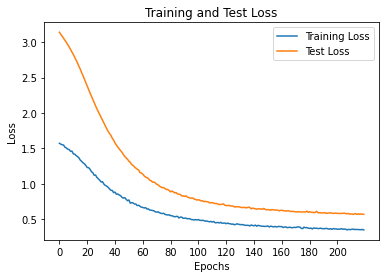

In [ ]:
# Load the training and validation loss dictionaries
train_loss_class = load(open('/content/drive/MyDrive/ML/train_loss_2_resnet.pkl', 'rb'))
test_loss_class = load(open('/content/drive/MyDrive/ML/test_loss_2_resnet.pkl', 'rb'))

# Retrieve each dictionary's values
train_values_class = train_loss_class.values()
test_values_class = test_loss_class.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values_class)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values_class)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

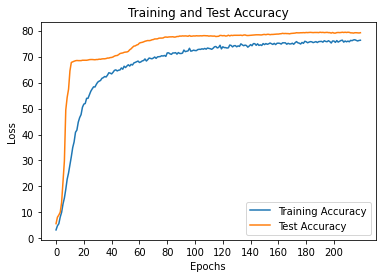

In [ ]:
# Load the training and validation loss dictionaries
train_acc = load(open('/content/drive/MyDrive/ML/train_acc_2_resnet.pkl', 'rb'))
test_acc = load(open('/content/drive/MyDrive/ML/test_acc_2_resnet.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_acc.values()
test_values = test_acc.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Accuracy')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Accuracy')

# Add in a title and axes labels
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filenames =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "EfficientNetB0_accuracy_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filenames)

classifier.save_weights(filenames)

/content/drive/MyDrive/Colab Notebooks/20230322-040014EfficientNetB0_accuracy_simclr.h5


##Prediction

In [ ]:
classifier.load_weights("/content/drive/MyDrive/Colab Notebooks/20230322-040014EfficientNetB0_accuracy_simclr.h5")

In [ ]:
X = tf.reshape(x_test[50], [1, 224, 224, 3]) ##need to reshape
classifier.predict(X)

1/1 [==============================] - 10s 10s/step


array([[5.0964323e-04, 1.6062794e-04, 2.9514488e-03, 7.5555021e-05,
        3.4447077e-03, 3.8623900e-04, 1.7271906e-03, 8.2802777e-05,
        3.3218765e-03, 5.6276034e-04, 5.5264670e-04, 6.0301933e-02,
        8.8947344e-01, 3.1713359e-02, 9.1672636e-04, 6.0179521e-04,
        5.6097878e-04, 1.0876636e-03, 4.2816575e-04, 1.3983388e-04,
        1.6847845e-04, 3.8131964e-04, 4.5082744e-04]], dtype=float32)

In [ ]:
y_predict = np.argmax(classifier.predict(x_test), axis=-1)
y_predict

67/67 [==============================] - 4s 57ms/step


array([18, 18, 11, ..., 16, 17, 12])

In [ ]:
#CONFUSIN MATRIX
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
class_names = ["cecum", "ileum", "retroflex_rectum", "hemorrhoids", "polyps","ulcerative_colitis_grade_0_1","ulcerative_colitis_grade_1","ulcerative_colitis_grade_1_2","ulcerative_colitis_grade_2","ulcerative_colitis_grade_2_3","ulcerative_colitis_grade_3","bbps_0_1" ,"bbps_2_3","impacted_stool","dyed_lifted_polyps","dyed_resection_margins","pylorus","retroflex_stomach","z_line","barretts","barretts_short_segment","esophagitis_a" ,"esophagitis_b_d"]
print(metrics.classification_report(y_test, y_predict, target_names=class_names))

                              precision    recall  f1-score   support

                       cecum       0.63      0.94      0.75       202
                       ileum       0.00      0.00      0.00         2
            retroflex_rectum       1.00      0.01      0.03        78
                 hemorrhoids       0.00      0.00      0.00         1
                      polyps       0.53      0.95      0.68       206
ulcerative_colitis_grade_0_1       0.00      0.00      0.00         7
  ulcerative_colitis_grade_1       0.00      0.00      0.00        40
ulcerative_colitis_grade_1_2       0.00      0.00      0.00         2
  ulcerative_colitis_grade_2       0.00      0.00      0.00        89
ulcerative_colitis_grade_2_3       0.00      0.00      0.00         5
  ulcerative_colitis_grade_3       0.00      0.00      0.00        27
                    bbps_0_1       0.92      0.65      0.76       129
                    bbps_2_3       0.82      1.00      0.90       230
              impac

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


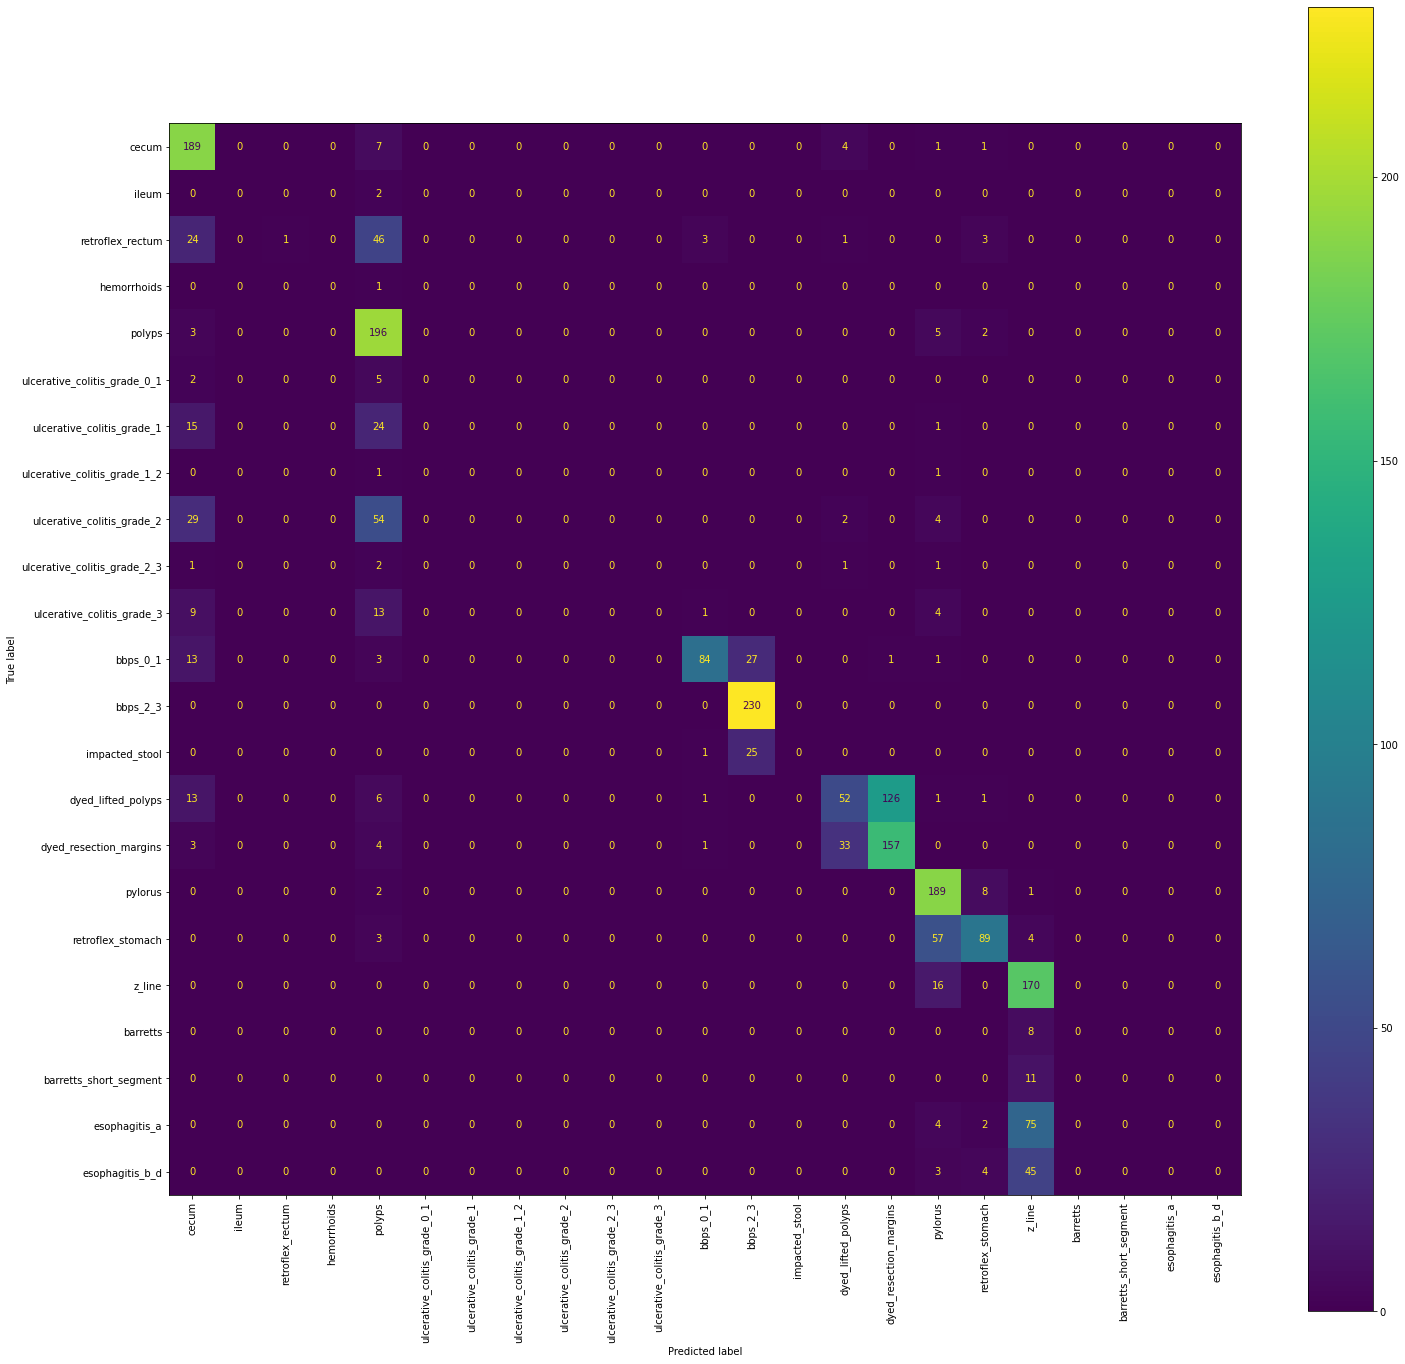

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = class_names)

plt.rcParams["figure.figsize"] = [24,24]
cm_display.plot(xticks_rotation = 'vertical')
plt.show()

In [ ]:
#check layers trainable
for i, layer in enumerate(classifier.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 input_2 [(None, 224, 224, 3)] False
1 rescaling_1 (None, 224, 224, 3) False
2 normalization_1 (None, 224, 224, 3) False
3 stem_conv_pad (None, 225, 225, 3) False
4 stem_conv (None, 112, 112, 32) False
5 stem_bn (None, 112, 112, 32) False
6 stem_activation (None, 112, 112, 32) False
7 block1a_dwconv (None, 112, 112, 32) False
8 block1a_bn (None, 112, 112, 32) False
9 block1a_activation (None, 112, 112, 32) False
10 block1a_se_squeeze (None, 32) False
11 block1a_se_reshape (None, 1, 1, 32) False
12 block1a_se_reduce (None, 1, 1, 8) False
13 block1a_se_expand (None, 1, 1, 32) False
14 block1a_se_excite (None, 112, 112, 32) False
15 block1a_project_conv (None, 112, 112, 16) False
16 block1a_project_bn (None, 112, 112, 16) False
17 block2a_expand_conv (None, 112, 112, 96) False
18 block2a_expand_bn (None, 112, 112, 96) False
19 block2a_expand_activation (None, 112, 112, 96) False
20 block2a_dwconv_pad (None, 113, 113, 96) False
21 block2a_dwconv (None, 56, 56, 96) False
22 block2a_bn (Non

#XAI

In [ ]:
##check if any error occurs here, if occurs, most likely graph not connected
def flatten_model(model):
    if not any(hasattr(layer, 'layers') for layer in model.layers):
        return model  # No sub-model defined within this model
    inputs = None
    outputs = None
    for layer in model.layers:
        if inputs is None:
            inputs = layer.input
        if hasattr(layer, 'layers'):
            submodel = layer
            last_layer = submodel.layers[-1]
            outputs = submodel.output

        if outputs is None:
            outputs = layer
        else:
            outputs = layer(outputs)
    return keras.Model(inputs=inputs, outputs=outputs)

flat_model = flatten_model(classifier)

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()
X = tf.convert_to_tensor(x_test[50], dtype=tf.float32)    ##need to convert the input data to tensor
y = y_test[50].item()   ##just a single integer value, no numpy array
score = CategoricalScore(y)

In [ ]:
image_titles = ['Image']
from matplotlib import cm

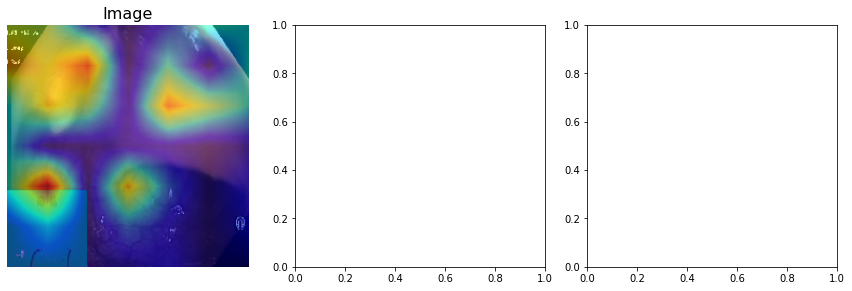

In [ ]:
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(classifier,
                  model_modifier=replace2linear,
                  clone=False)

grad_cam = gradcam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap1 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap1, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

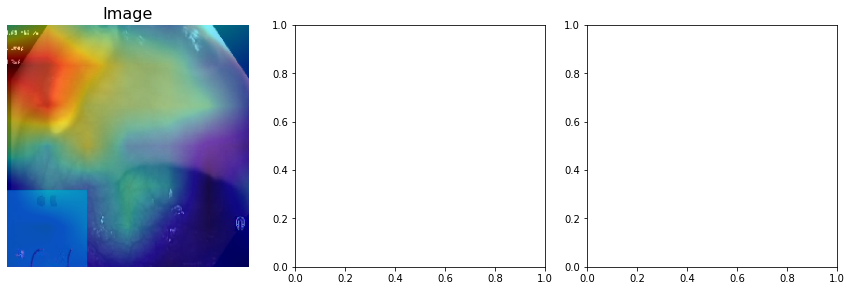

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(classifier, model_modifier=replace2linear,clone=False)

# Generate heatmap with GradCAM++
grad_cam = gradcam(score, X, penultimate_layer=-1)
# Render
#for i, title in enumerate(image_titles):
#    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap2, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

40/40 [==============================] - 4s 51ms/step


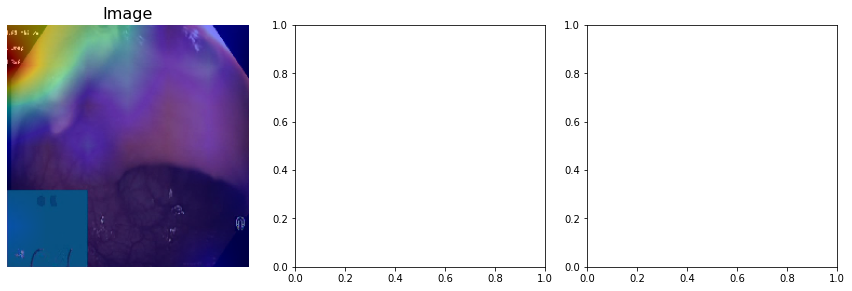

In [ ]:
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with ScoreCAM
grad_cam = scorecam(score, X, penultimate_layer=-1, max_N=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap3 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap3, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 2s 2s/step


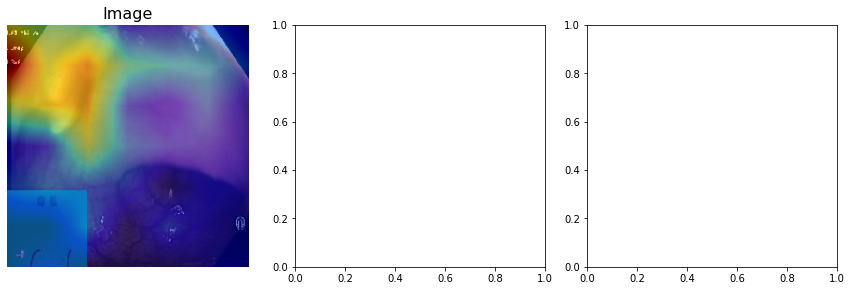

In [ ]:
# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with Faster-ScoreCAM
grad_cam = scorecam(score,X,penultimate_layer=-1,max_N=10)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap4 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap4, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

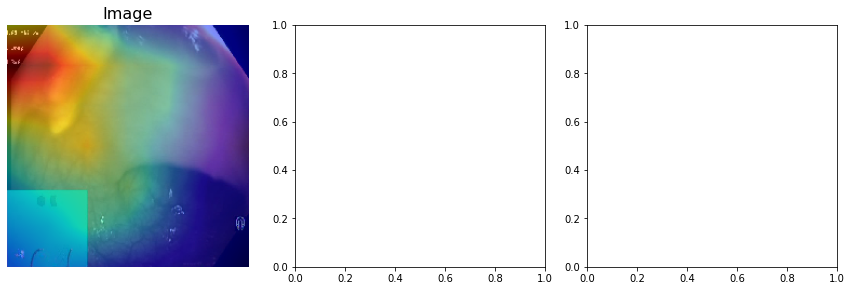

In [ ]:
from tf_keras_vis.layercam import Layercam

layercam = Layercam(classifier, model_modifier=replace2linear,clone = False)

# Generate heatmap with Faster-ScoreCAM
grad_cam = layercam(score,X,penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap5 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap5, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

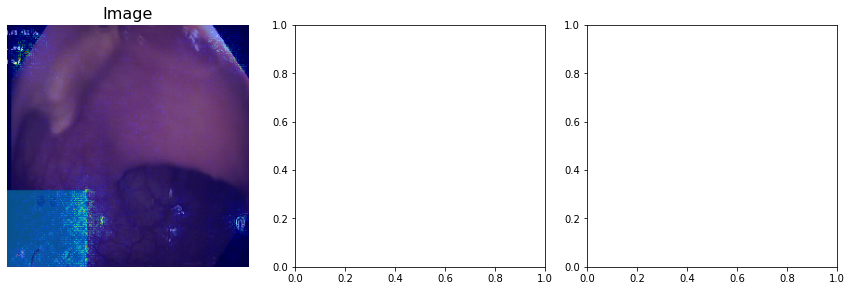

In [ ]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(classifier, model_modifier=replace2linear,clone=False)

# Generate saliency map
saliency_map_van = saliency(score, X)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap6 = np.uint8(cm.jet(saliency_map_van[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap6, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

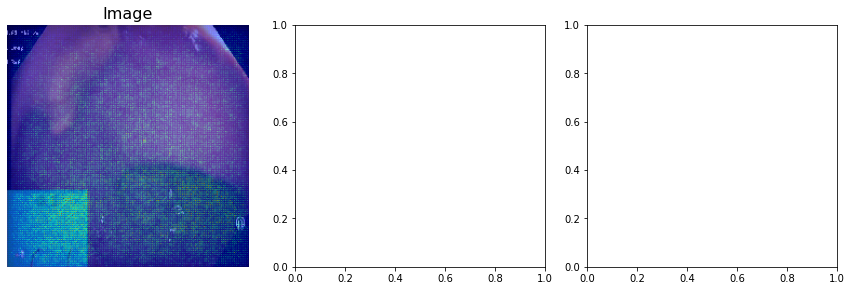

In [ ]:
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map_smooth = saliency(score,X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap7 = np.uint8(cm.jet(saliency_map_smooth[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap7, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

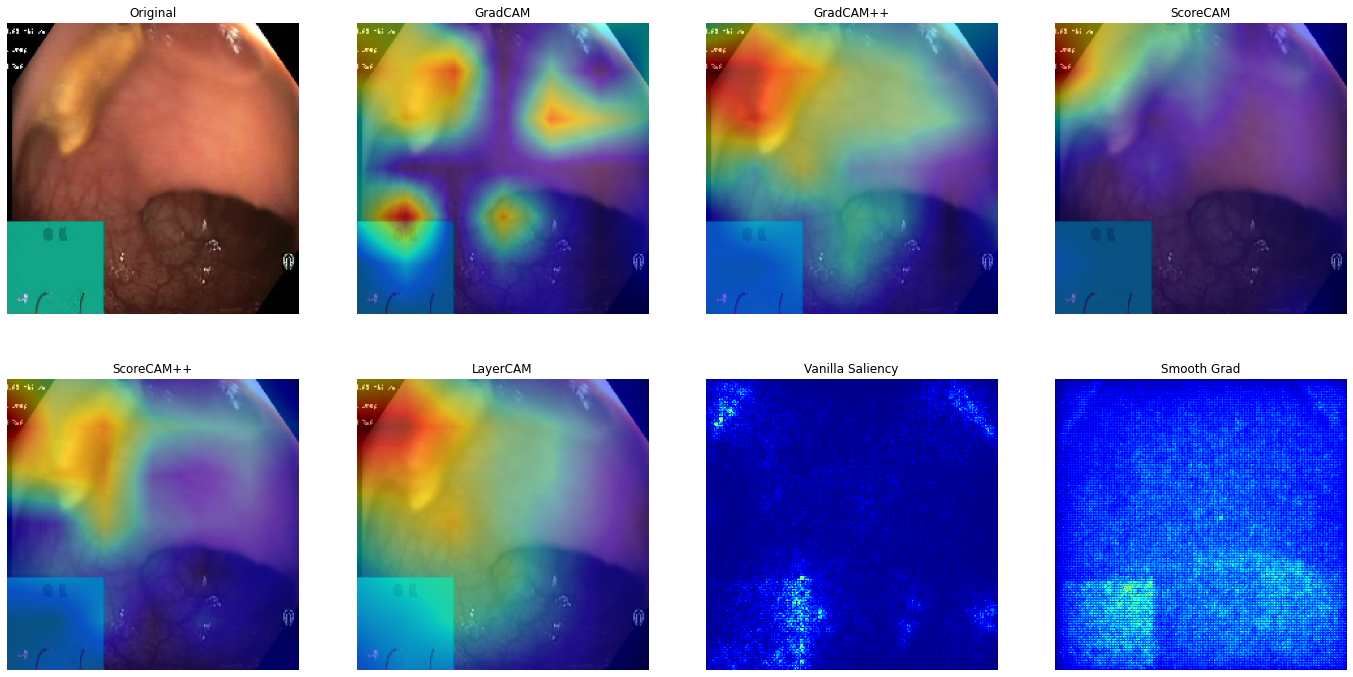

In [ ]:
# Render
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))

ax[0][0].set_title("Original", fontsize=12)
ax[0][0].imshow(x_test[50])
ax[0][0].axis('off')

ax[0][1].set_title("GradCAM", fontsize=12)
ax[0][1].imshow(x_test[50])
ax[0][1].imshow(heatmap1, cmap='jet', alpha=0.5)
ax[0][1].axis('off')

ax[0][2].set_title("GradCAM++", fontsize=12)
ax[0][2].imshow(x_test[50])
ax[0][2].imshow(heatmap2, cmap='jet', alpha=0.5)
ax[0][2].axis('off')

ax[0][3].set_title("ScoreCAM", fontsize=12)
ax[0][3].imshow(x_test[50])
ax[0][3].imshow(heatmap3, cmap='jet', alpha=0.5)
ax[0][3].axis('off')

ax[1][0].set_title("ScoreCAM++", fontsize=12)
ax[1][0].imshow(x_test[50])
ax[1][0].imshow(heatmap4, cmap='jet', alpha=0.5)
ax[1][0].axis('off')

ax[1][1].set_title("LayerCAM", fontsize=12)
ax[1][1].imshow(x_test[50])
ax[1][1].imshow(heatmap5, cmap='jet', alpha=0.5)
ax[1][1].axis('off')

ax[1][2].set_title("Vanilla Saliency", fontsize=12)
ax[1][2].imshow(saliency_map_van[0], cmap='jet')
ax[1][2].axis('off')

ax[1][3].set_title("Smooth Grad", fontsize=12)
ax[1][3].imshow(saliency_map_smooth[0], cmap='jet')
ax[1][3].axis('off')

plt.show()